In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime as dt

# Scikit-learn imports
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, classification_report, balanced_accuracy_score)
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.compose import ColumnTransformer

# Imbalanced-learn imports
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Use Python to extract the .csv from the .zip:
import zipfile
import os


In [11]:
zip_files = ['SpotifyAudioFeaturesApril2019.csv.zip', 'SpotifyAudioFeaturesNov2018.csv.zip']
csv_files = ['SpotifyAudioFeaturesApril2019.csv', 'SpotifyAudioFeaturesNov2018.csv']

# Unzip each file
for zip_file, csv_file in zip(zip_files, csv_files):
    if not os.path.exists(csv_file):  # Only unzip if the CSV file doesn't already exist
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall()  # Extract the files to the current directory
        print(f"Extracted {csv_file}")
    else:
        print(f"{csv_file} already exists, skipping extraction.")

# Read the CSV files into pandas DataFrames
df2 = pd.read_csv('SpotifyAudioFeaturesApril2019.csv')
df1 = pd.read_csv('SpotifyAudioFeaturesNov2018.csv')

# Show the first few rows of each DataFrame
print("April 2019 Data:")
display(df2.head(3))

print("\nNovember 2018 Data:")
display(df1.head(3))


SpotifyAudioFeaturesApril2019.csv already exists, skipping extraction.
SpotifyAudioFeaturesNov2018.csv already exists, skipping extraction.
April 2019 Data:


,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.00582,0.743,238373,0.339,0.0,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.02440,0.846,214800,0.557,0.0,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,0
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.02500,0.603,138913,0.723,0.0,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,56



November 2018 Data:


,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.00582,0.743,238373,0.339,0.0,1,0.0812,-7.678,1,0.4090,203.927,4,0.118,44
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.02440,0.846,214800,0.557,0.0,8,0.2860,-7.259,1,0.4570,159.009,4,0.371,10
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.02500,0.603,138913,0.723,0.0,9,0.0824,-5.890,0,0.0454,114.966,4,0.382,63


In [12]:
df = pd.concat([df1, df2])

In [13]:
df

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.005820,0.743,238373,0.339,0.000,1,0.0812,-7.678,1,0.4090,203.927,4,0.1180,44
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.024400,0.846,214800,0.557,0.000,8,0.2860,-7.259,1,0.4570,159.009,4,0.3710,10
2,R3HAB,6Wosx2euFPMT14UXiWudMy,Radio Silence,0.025000,0.603,138913,0.723,0.000,9,0.0824,-5.890,0,0.0454,114.966,4,0.3820,63
3,Chris Cooq,3J2Jpw61sO7l6Hc7qdYV91,Lactose,0.029400,0.800,125381,0.579,0.912,5,0.0994,-12.118,0,0.0701,123.003,4,0.6410,9
4,Chris Cooq,2jbYvQCyPgX3CdmAzeVeuS,Same - Original mix,0.000035,0.783,124016,0.792,0.878,7,0.0332,-10.277,1,0.0661,120.047,4,0.9280,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130658,Calum Scott,0cvfSKcm9VeduwyYPrxtLx,Come Back Home,0.006780,0.601,190539,0.801,0.000,11,0.0991,-5.174,1,0.0323,131.049,4,0.2890,57
130659,Saint Claire,43MP9F7UzvfilSrw2SqZGJ,Enough for You,0.918000,0.387,194583,0.249,0.000,9,0.1030,-13.233,1,0.0437,94.039,4,0.3460,60
130660,Mike Stud,4TWlUuFk81NGUNKwndyS5Q,Do It,0.330000,0.717,139191,0.532,0.000,8,0.0997,-8.351,0,0.2060,156.977,4,0.5460,47
130661,D Savage,5iGBXzOoRo4sBTy8wdzMyK,No Smoke,0.007900,0.772,180013,0.510,0.000,4,0.1310,-9.670,0,0.1200,120.049,4,0.0755,50


In [14]:
unique_count_A = df['track_id'].nunique()
unique_count_A

130989

In [15]:
df_cleaned = df.drop_duplicates(subset='track_id')
track_id = df_cleaned['track_id']
track_name = df_cleaned['track_name']
df_cleaned.drop(columns=['track_id', 'track_name', 'artist_name'], inplace=True)

/var/folders/f4/znkgg6px5fj7653xldc0dbxr0000gn/T/ipykernel_20972/53648802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=['track_id', 'track_name', 'artist_name'], inplace=True)


In [16]:
df_cleaned

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,0.005820,0.743,238373,0.339,0.000000,1,0.0812,-7.678,1,0.4090,203.927,4,0.1180,44
1,0.024400,0.846,214800,0.557,0.000000,8,0.2860,-7.259,1,0.4570,159.009,4,0.3710,10
2,0.025000,0.603,138913,0.723,0.000000,9,0.0824,-5.890,0,0.0454,114.966,4,0.3820,63
3,0.029400,0.800,125381,0.579,0.912000,5,0.0994,-12.118,0,0.0701,123.003,4,0.6410,9
4,0.000035,0.783,124016,0.792,0.878000,7,0.0332,-10.277,1,0.0661,120.047,4,0.9280,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130643,0.279000,0.654,205034,0.788,0.000000,9,0.1900,-4.735,0,0.2060,152.032,4,0.4720,44
130649,0.105000,0.294,388600,0.652,0.001960,5,0.3780,-7.314,1,0.0336,75.335,4,0.1670,64
130653,0.108000,0.678,196364,0.795,0.000000,10,0.0995,-6.126,0,0.3440,176.157,4,0.9240,49
130656,0.668000,0.211,279070,0.284,0.000111,1,0.1050,-10.317,1,0.0385,83.905,4,0.0638,51


In [17]:
#First attempt at modeling
#Using RandomForest due to potential multicollinearity and large sample size (~130000)



# Separate features and target
X = df_cleaned.drop('popularity', axis=1)
y = df_cleaned['popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2:.4f}")

# Calculate Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

R-squared score: 0.1602
Root Mean Squared Error: 17.3146
Mean Absolute Error: 13.9954

Feature Importance:
             feature  importance
7           loudness    0.152037
2        duration_ms    0.099090
3             energy    0.093149
0       acousticness    0.090264
1       danceability    0.090061
12           valence    0.089741
10             tempo    0.089267
9        speechiness    0.086233
6           liveness    0.080122
4   instrumentalness    0.071425
5                key    0.042279
8               mode    0.009377
11    time_signature    0.006956


In [18]:
#We can see in the above result that all metrics look BAD. We are going to have to do a little tweaking.
df['popularity'].value_counts()

popularity
0      30393
1       5584
19      5101
17      4986
22      4913
       ...  
96         8
98         4
97         2
100        2
99         1
Name: count, Length: 101, dtype: int64

In [19]:
#Trying RandomUnderSample to help balance the dataset. My idea is that since the majority of this data set skews towards unpopular songs due to the dataset itself being compiled randomly,
#I will try to enforce a more even distribution so our model has a higher percentage of Popularity values to work with


X = df_cleaned.drop('popularity', axis=1)
y = df_cleaned['popularity']

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2:.4f}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

R-squared score: 0.4552
Mean Absolute Error: 17.8929
Root Mean Squared Error: 21.8751

Feature Importance:
             feature  importance
7           loudness    0.237369
4   instrumentalness    0.204837
1       danceability    0.128070
9        speechiness    0.086715
6           liveness    0.068667
0       acousticness    0.054775
5                key    0.047747
10             tempo    0.044876
3             energy    0.041856
2        duration_ms    0.040337
12           valence    0.032872
11    time_signature    0.007887
8               mode    0.003991


In [20]:
#We immediately get stronger performance with RandomUnderSampling, let's see what steps we can take to further optimize

In [21]:
#Trying GridSearchCV to find optimal values for our RandomForest model

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

In [22]:
best_model

RandomForestRegressor(min_samples_split=10, n_estimators=200, random_state=42)

In [23]:
#I see that our best model adds min_samples_split, and changes our n_estimators from 100 from 200, so let's try that

In [24]:
X = df_cleaned.drop('popularity', axis=1)
y = df_cleaned['popularity']

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(min_samples_split=10, n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2:.4f}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

R-squared score: 0.4941
Mean Absolute Error: 17.5903
Root Mean Squared Error: 21.0808

Feature Importance:
             feature  importance
7           loudness    0.281649
4   instrumentalness    0.214781
1       danceability    0.139431
9        speechiness    0.089575
6           liveness    0.047963
0       acousticness    0.045777
5                key    0.043761
10             tempo    0.041040
3             energy    0.031520
12           valence    0.029050
2        duration_ms    0.027807
11    time_signature    0.006158
8               mode    0.001489


In [25]:
#An increase of 4% from previous, another good optimization 

In [26]:
scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Cross-validated R-squared scores: {scores}")

Cross-validated R-squared scores: [ 0.43830285  0.04629509  0.46029329 -0.24091565  0.15850953]


In [27]:
#cross validated scores show me this model is very inconsistent. great :)

#Let's try some additional hyperparameter optimization and feature selection on our undersampled data 

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd



#Pipeline that handles hyperparameter tuning and feature selection all in 1
#Since our RandomUnderSampled data is smaller, we can search with a much further depth than previously


X = df_cleaned.drop('popularity', axis=1)
y = df_cleaned['popularity']

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define hyperparameters to search
param_grid = {
    'rf__n_estimators': [50, 100, 200, 250, 300, 350, 400, 450, 500],
    'rf__max_depth': [None, 5, 10, 15, 20, 25,],
    'rf__min_samples_split': [2,3,4,5]
}

# Perform randomized search with cross-validation
randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, cv=5, scoring='r2', n_jobs=-1)
randomized_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", randomized_search.best_params_)
print("Best cross-validation score:", randomized_search.best_score_)

# Evaluate on test set
test_score = randomized_search.score(X_test, y_test)
print("Test set R-squared score:", test_score)

# Get feature importances
best_model = randomized_search.best_estimator_
feature_importances = best_model.named_steps['rf'].feature_importances_

# Create a DataFrame for better handling
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print selected features and their importances in descending order
for index, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

Best parameters: {'rf__n_estimators': 500, 'rf__min_samples_split': 3, 'rf__max_depth': 5}
Best cross-validation score: 0.17006614080059412
Test set R-squared score: 0.48345286223962447
loudness: 0.2614
instrumentalness: 0.2001
danceability: 0.1392
speechiness: 0.0924
liveness: 0.0503
tempo: 0.0475
key: 0.0462
acousticness: 0.0459
energy: 0.0371
duration_ms: 0.0364
valence: 0.0342
time_signature: 0.0055
mode: 0.0037


In [31]:

#We get the above output of the pipeline, let's try it out


X = df_cleaned.drop('popularity', axis=1)
y = df_cleaned['popularity']

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest model with the best parameters
rf_model = RandomForestRegressor(n_estimators=500, min_samples_split=2, max_depth=20, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2:.4f}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

R-squared score: 0.4718
Mean Absolute Error: 17.6470
Root Mean Squared Error: 21.5401

Feature Importance:
             feature  importance
7           loudness    0.249222
4   instrumentalness    0.190226
1       danceability    0.134601
9        speechiness    0.090623
6           liveness    0.054594
10             tempo    0.051509
0       acousticness    0.048755
5                key    0.048486
3             energy    0.041418
2        duration_ms    0.040502
12           valence    0.039080
11    time_signature    0.006139
8               mode    0.004846


In [32]:
#It performs worse.

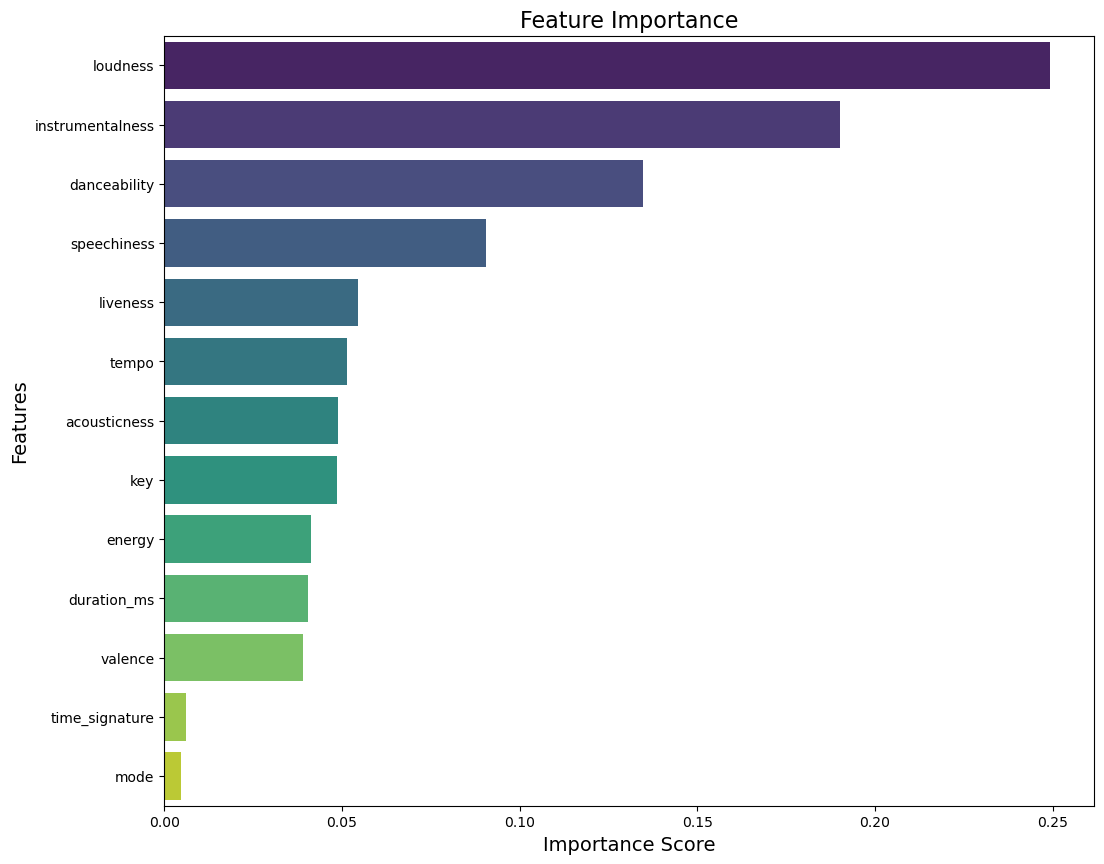

In [33]:
#plotting feature importance

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Show the plot
plt.show()

In [34]:
df_reduced = df_cleaned.copy().drop(columns=['mode','time_signature','duration_ms', 'valence'])


In [35]:
df_reduced

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,popularity
0,0.005820,0.743,0.339,0.000000,1,0.0812,-7.678,0.4090,203.927,44
1,0.024400,0.846,0.557,0.000000,8,0.2860,-7.259,0.4570,159.009,10
2,0.025000,0.603,0.723,0.000000,9,0.0824,-5.890,0.0454,114.966,63
3,0.029400,0.800,0.579,0.912000,5,0.0994,-12.118,0.0701,123.003,9
4,0.000035,0.783,0.792,0.878000,7,0.0332,-10.277,0.0661,120.047,8
...,...,...,...,...,...,...,...,...,...,...
130643,0.279000,0.654,0.788,0.000000,9,0.1900,-4.735,0.2060,152.032,44
130649,0.105000,0.294,0.652,0.001960,5,0.3780,-7.314,0.0336,75.335,64
130653,0.108000,0.678,0.795,0.000000,10,0.0995,-6.126,0.3440,176.157,49
130656,0.668000,0.211,0.284,0.000111,1,0.1050,-10.317,0.0385,83.905,51


In [36]:
#Messing around with removing features and using otherwise identical code to our highest scoring model above
#Once again, we've managed to lose a marginal amount of accuracy. Nothing meaningful

X = df_reduced.drop('popularity', axis=1)
y = df_reduced['popularity']

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(min_samples_split=10, n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2:.4f}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

R-squared score: 0.4905
Mean Absolute Error: 17.6400
Root Mean Squared Error: 21.1546

Feature Importance:
            feature  importance
6          loudness    0.296939
3  instrumentalness    0.221698
1      danceability    0.146418
7       speechiness    0.094603
5          liveness    0.053844
0      acousticness    0.051539
4               key    0.048552
8             tempo    0.047517
2            energy    0.038890


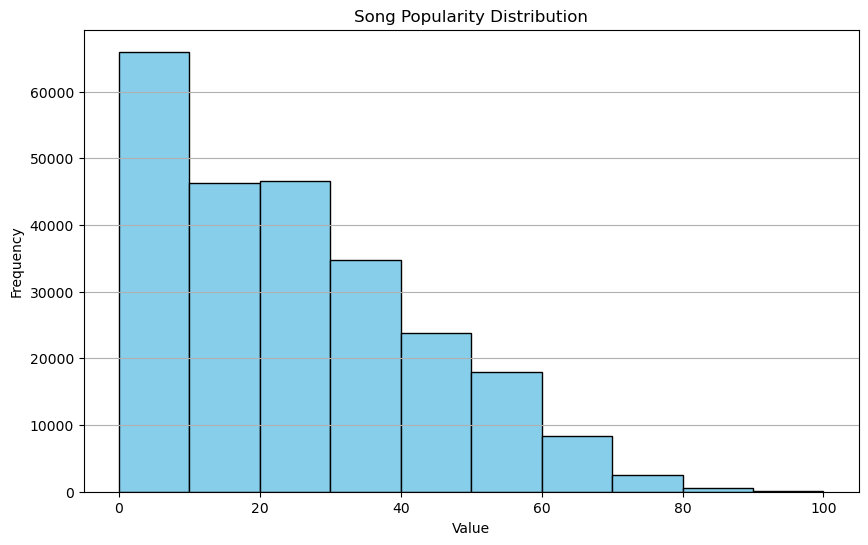

In [37]:
#Shows distribution of popular songs. Use as visual explanation for why we chose RandomUnderSampler

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['popularity'], bins=10, range=(0, 100), color='skyblue', edgecolor='black')
plt.title('Song Popularity Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

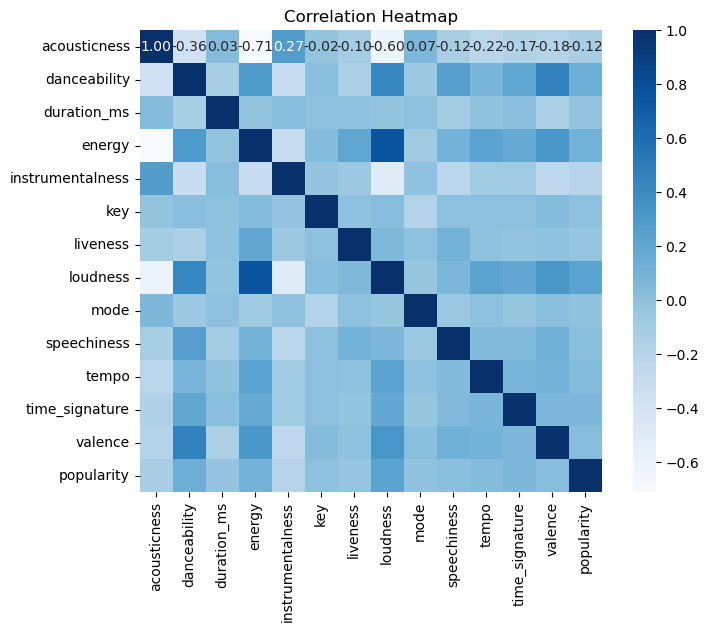

In [38]:
#Initial heatmap showing correlations between our variables. We notice popularity has some.. not so strong correlations

matrix = df_cleaned.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.show()